# BERT Fine Tuning


## A. Set up environment


In [0]:
!pip install bert-for-tf2
!pip install sentencepiece

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm

from collections import namedtuple

print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)

TensorFlow Version: 2.1.0
Hub version:  0.7.0


In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Suppress new window for plots
%matplotlib inline 

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
from google.colab import files, drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls

drive  sample_data


## B. Functions

Plotting Functions

In [0]:
def plot_cm(y_true, y_pred, figsize=(10,8)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    fig, ax = plt.subplots(figsize=figsize)
    colormap = sns.diverging_palette(220, 20, sep=20, as_cmap=True) #plt.cm.coolwarm #coolwarm_r reverse
    sns.heatmap(cm, 
                cmap=colormap, 
                annot=annot, 
                annot_kws={"size": 12}, 
                fmt='',
                linewidths=1, 
                square=True, 
                ax=ax)
    ax.set_title('Confusion Matrix\n\n', fontsize=14); 
    ax.set_xlabel('\n\nPredicted Label', fontsize=12);
    ax.set_ylabel('Actual Label\n\n', fontsize=12);

BERT Related Functions

In [0]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

## C. Import Pre-Processed Dataset

In [0]:
print(os.getcwd())
path_to_data = "/content/drive/My Drive/Colab Notebooks/W266 Final Project/data/"
filename = "ticket_data_pp.csv"

/content


In [0]:
ticket_data = pd.read_csv(path_to_data + filename, dtype = {'Notes': str})
ticket_data.Notes = ticket_data.Notes.fillna(' ')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


View dataframe

In [0]:
ticket_data.columns

Index(['Unnamed: 0', 'BugActionID', 'BugID', 'ActionUserID', 'ActionTime',
       'AssignedID', 'Notes', 'StatusID', 'PriorityID', 'BAContactID',
       'UpdateType', 'ResolutionID', 'ClientTouched', 'CodeChanged',
       'ClientEmailed', 'ClientPhoned', 'UserDepartment', 'UserPosition',
       'NextBugActionID', 'LastTouchPrevToCloseID', 'OpenAfterCloseID',
       'NextCloseConfirmedID', 'RawHours', 'BusinessHours', 'LastCloseID',
       'ActionOrder', 'RedirectStatus', 'Title', 'Directory', 'ProductID',
       'ReportedID', 'Description', 'compid', 'contactid', 'Originated',
       'KBArticleID', 'CurrentResolutionID', 'OpenedTime', 'LastBugActionID',
       'WasLow', 'WasAssignedToDev', 'LastBugActionStatus', 'NumBugActions',
       'LastContact', 'WasEscalatedPastRepLevel', 'WorkspaceID', 'Summary',
       'ClientTemp', 'MajorityPriorityID', 'SupportFailbyDev',
       'SupportFailConfirm', 'Classification', 'HighestPriorityID', 'owner',
       'IsEFP', 'LastRedirectStatus', 'Change

In [0]:
ticket_data.head(5)

,Unnamed: 0,BugActionID,BugID,ActionUserID,ActionTime,AssignedID,Notes,StatusID,PriorityID,BAContactID,UpdateType,ResolutionID,ClientTouched,CodeChanged,ClientEmailed,ClientPhoned,UserDepartment,UserPosition,NextBugActionID,LastTouchPrevToCloseID,OpenAfterCloseID,NextCloseConfirmedID,RawHours,BusinessHours,LastCloseID,ActionOrder,RedirectStatus,Title,Directory,ProductID,ReportedID,Description,compid,contactid,Originated,KBArticleID,CurrentResolutionID,OpenedTime,LastBugActionID,WasLow,WasAssignedToDev,LastBugActionStatus,NumBugActions,LastContact,WasEscalatedPastRepLevel,WorkspaceID,Summary,ClientTemp,MajorityPriorityID,SupportFailbyDev,SupportFailConfirm,Classification,HighestPriorityID,owner,IsEFP,LastRedirectStatus,ChangeDateTime,HistorySummary,HistoryClientTemp,UserID,ClosestBugActionID,ArticleID,KBTitle,NumUses,NumTimesEscalated,DefaultPriorityID,PackageID,KBProductID,Active,UserFriendlyDesc,SalesProductGroupID,DefaultClassification,PriorityID_Int,clean_notes,tokenized_notes,EmptyNote,label_pr_low,label_pr_norm,label_pr_high,label_pr_crit
0,0,3486141,505111,TaxServiceSupport,2019-12-01 09:56:38.470000000,TaxServiceSupport,(Created),Open,Normal,41190.0,Opened,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3486142.0,NaN,NaN,NaN,0.0000,0.0000,NaN,1,NaN,EFP: Submission hung or stalling,NaN,NaN,TaxServiceSupport,Error in EFP,3701,41190,NaN,1545,0.0,2019-12-01 14:56:37.973000000,3486423,False,True,Closed,5,2019-12-02 10:14:47.060000000,True,NaN,NaN,NaN,NaN,NaN,NaN,Not Support Related,Normal,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,1545,EFP: Submission hung or stalling,0,0,High,-1,40,0,NaN,30,NaN,1,created,['created'],0,0,1,0,0
1,1,3486142,505111,TaxServiceSupport,2019-12-01 09:56:41.313000000,Tax Service Support,**EFP-Auto-Ticket-Action** Error while handli...,In Progress,Normal,41190.0,Working,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3486361.0,NaN,NaN,NaN,23.8833,0.8167,NaN,2,NaN,EFP: Submission hung or stalling,NaN,NaN,TaxServiceSupport,Error in EFP,3701,41190,NaN,1545,0.0,2019-12-01 14:56:37.973000000,3486423,False,True,Closed,5,2019-12-02 10:14:47.060000000,True,NaN,NaN,NaN,NaN,NaN,NaN,Not Support Related,Normal,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,1545,EFP: Submission hung or stalling,0,0,High,-1,40,0,NaN,30,NaN,1,efp auto ticket action error while handli...,"['efp', 'auto', 'ticket', 'action', 'error', '...",0,0,1,0,0
2,2,3486361,505111,jbaughn,2019-12-02 09:49:36.447000000,TFC/PTS Development,this seems to be stuck on submitting,In Progress,Normal,41190.0,Redirected,0.0,False,False,False,False,Payroll Tax Service,Tax Service Support Manager,3486397.0,NaN,NaN,NaN,0.2000,0.2000,NaN,3,NaN,EFP: Submission hung or stalling,NaN,NaN,TaxServiceSupport,Error in EFP,3701,41190,NaN,1545,0.0,2019-12-01 14:56:37.973000000,3486423,False,True,Closed,5,2019-12-02 10:14:47.060000000,True,NaN,NaN,NaN,NaN,NaN,NaN,Not Support Related,Normal,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,1545,EFP: Submission hung or stalling,0,0,High,-1,40,0,NaN,30,NaN,1,this seems to be stuck on submitting,"['this', 'seems', 'to', 'be', 'stuck', 'on', '...",0,0,1,0,0
3,3,3486397,505111,aking,2019-12-02 10:01:27.193000000,jbaughn,submitted 270973601625361,Fixed,Normal,41190.0,Fixed,0.0,False,False,False,False,Development,Development Technician 3,3486423.0,NaN,NaN,NaN,0.2167,0.2167,NaN,4,NaN,EFP: Submission hung or stalling,NaN,NaN,TaxServiceSupport,Error in EFP,3701,41190,NaN,1545,0.0,2019-12-01 14:56:37.973000000,3486423,False,True,Closed,5,2019-12-02 10:14:47.060000000,True,NaN,NaN,NaN,NaN,NaN,NaN,Not Support Related,Normal,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,1545,EFP: Submission hung or stalling,0,0,High,-1,40,0,NaN,30,NaN,1,submitted,['submitted'],0,0,1,0,0
4,4,3486423,505111,jbaughn,2019-12-02 10:14:47.060000000,jbaughn,closing,Closed,Normal,41190.0,Worked,0.0,True,False,True,False,Payroll Tax Service,Tax Service Support Manager,NaN,3486397.0,NaN,NaN,NaN,NaN,3486423.0,5,NaN,EFP: Submission hung or stalling,NaN,NaN,TaxServiceSupport,Error in EFP,3701,41190,NaN,1545,0.0,2019-12-01 14:56:37.973000000,3486423,False,T

In [0]:
dataset = ticket_data[['PriorityID', 'PriorityID_Int', 'clean_notes',
                       'label_pr_low','label_pr_norm', 
                       'label_pr_high', 'label_pr_crit']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24199 entries, 0 to 24198
Data columns (total 7 columns):
PriorityID        24199 non-null object
PriorityID_Int    24199 non-null int64
clean_notes       24198 non-null object
label_pr_low      24199 non-null int64
label_pr_norm     24199 non-null int64
label_pr_high     24199 non-null int64
label_pr_crit     24199 non-null int64
dtypes: int64(5), object(2)
memory usage: 1.3+ MB


In [0]:
dataset["clean_notes"] = dataset["clean_notes"].apply(str)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24199 entries, 0 to 24198
Data columns (total 7 columns):
PriorityID        24199 non-null object
PriorityID_Int    24199 non-null int64
clean_notes       24199 non-null object
label_pr_low      24199 non-null int64
label_pr_norm     24199 non-null int64
label_pr_high     24199 non-null int64
label_pr_crit     24199 non-null int64
dtypes: int64(5), object(2)
memory usage: 1.3+ MB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
dataset = dataset.rename(columns={"PriorityID_Int": "label", 
                                  "clean_notes": "text"})
dataset.head(5)

,PriorityID,label,text,label_pr_low,label_pr_norm,label_pr_high,label_pr_crit
0,Normal,1,created,0,1,0,0
1,Normal,1,efp auto ticket action error while handli...,0,1,0,0
2,Normal,1,this seems to be stuck on submitting,0,1,0,0
3,Normal,1,submitted,0,1,0,0
4,Normal,1,closing,0,1,0,0


Split dataset into train and test

In [0]:
train, test = train_test_split(dataset,
                               test_size=0.2, 
                               shuffle=True)

In [0]:
print("train shape: ", train.shape)
print("test shape:  ", test.shape)

train shape:  (19359, 7)
test shape:   (4840, 7)


## D. Modeling

### D.0 Define Global Model-Related Variables

In [0]:
bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"

MAX_SEQ_LEN = 128

### D.1 Define BERT Layer

In [0]:
bert_layer = hub.KerasLayer(bert_path, 
                            trainable=True,
                            name="bert_layer")

input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), 
                                       dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), 
                                   dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), 
                                    dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [0]:
FullTokenizer = bert.bert_tokenization.FullTokenizer

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

### D.2 Define Custom Layers

In [0]:
layer1 = tf.keras.layers.GlobalAveragePooling1D(name="layer1")(sequence_output)

## Uncomment to run all custom layers
#dropouts1 = tf.keras.layers.Dropout(0.2)(layer1)
#
#layer2 = tf.keras.layers.Dense(64, activation='relu', 
#                               name = "First_Dense_Layer")(dropouts1)
#layer3 = tf.keras.layers.Dense(32, activation='relu', 
#                               name = "Second_Dense_Layer")(layer2)
#layer4 = tf.keras.layers.Dense(16, activation='relu', 
#                               name = "Third_Dense_Layer")(layer3)
#
#
#out = tf.keras.layers.Dense(4, # We need the output predictions for each of the four categories
#                            activation="sigmoid", # Because we want the probability of each class
#                            name="dense_output")(layer4)

In [0]:
out = tf.keras.layers.Dense(4, # We need the output predictions for each of the four categories
                            activation="sigmoid", # Because we want the probability of each class
                            name="dense_output")(layer1)

### D.3 Preview Model Architecture

In [0]:
model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], 
                              outputs=out)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer (KerasLayer)         [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

### D.4 Train Model

In [0]:
train_sentences = train.text
list_classes = ['label_pr_low', 'label_pr_norm', 'label_pr_high', 'label_pr_crit']
train_y = train[list_classes].values

In [0]:
def create_single_input(sentence, MAX_LEN):
  stokens = tokenizer.tokenize(sentence)
  stokens = stokens[:MAX_LEN]
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)

  return ids, masks, segments

In [0]:
def create_input_array(sentences):
  input_ids, input_masks, input_segments = [], [], []

  for sentence in tqdm(sentences,position=0, leave=True):
    ids, masks, segments = create_single_input(sentence, MAX_SEQ_LEN-2)
    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)

  return [np.asarray(input_ids, dtype=np.int32),
          np.asarray(input_masks, dtype=np.int32), 
          np.asarray(input_segments, dtype=np.int32)]

In [0]:
train_x = create_input_array(train_sentences)

100%|██████████| 19359/19359 [00:16<00:00, 1150.62it/s]


In [0]:
model.fit(train_x, train_y,
          epochs=1,
          batch_size=32,
          validation_split=0.2,
          shuffle=True)

Train on 15487 samples, validate on 3872 samples
15487/15487 [==============================] - 245s 16ms/sample - loss: 0.2641 - accuracy: 0.9198 - val_loss: 0.2433 - val_accuracy: 0.9246


### D.5 Evaluate Model

In [0]:
test_sentences = test.text
test_x = create_input_array(test_sentences)

test_pred = model.predict(test_x)

100%|██████████| 4840/4840 [00:04<00:00, 1147.65it/s]


In [0]:
y_pred = np.argmax(test_pred, axis=1)
y_true = test.label.values

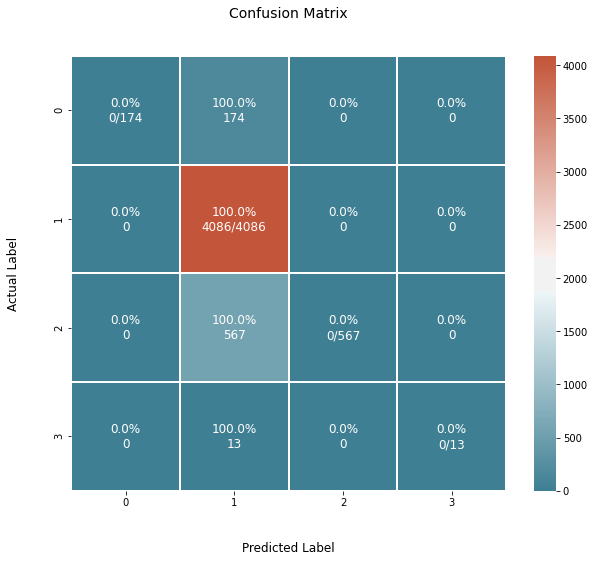

In [0]:
plot_cm(y_true, y_pred)